# Datasets comparison between CAMS and TROPOMI (L3)

## Imports and supporting functions

In [1]:
# Related to the system
import os 

# Related to the data retrieval
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import geojson
import urllib3
import subprocess # Important for GOME-2 and TROPOMI L3
import gzip # Important for TROPOMI L3

# Related to the data analysis
import math
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
from itertools import product
import scipy.interpolate
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist

# Related to the results
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display
import warnings

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_tropomi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

# Hide API request warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Increase animation limit
matplotlib.rcParams['animation.embed_limit'] = 25000000

# Hide labels animation warning
warnings.filterwarnings('ignore', category = UserWarning, module='cartopy')

## 1. Define datasets

In [4]:
# Define component (NO2)
component_nom = 'NO2'

# Define model
model = 'cams'
model_full_name = 'cams-global-reanalysis-eac4-monthly'

# Define sensor
sensor = 'tropomi'
sensor_type = 'L3'
apply_kernels = False

# Define search period
start_date = '2020-01-01'
end_date = '2020-12-31'

# Define extent
lon_min = -25
lon_max = 45
lat_min = 30
lat_max = 70

In [5]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


In [6]:
# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

# Create bbox
bbox = search_bbox(lon_min, lat_min, lon_max, lat_max)

SEARCH PERIOD
- In months: ('2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12')
SEARCH BOUNDING BOX
Latitudes: from 30 to 70
Longitudes: from -25 to 45


## 2. Model data

### Download and read data as xarray

In [7]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single',
                                               CAMS_UID = None, CAMS_key = None)

2021-12-11 23:08:15,946 INFO Welcome to the CDS
2021-12-11 23:08:15,946 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-reanalysis-eac4-monthly
2021-12-11 23:08:15,960 INFO Request is queued


The file does not exist, it will be downloaded.


2021-12-11 23:08:16,969 INFO Request is running
2021-12-11 23:08:20,739 INFO Request is completed
2021-12-11 23:08:20,740 INFO Downloading https://download-0003.copernicus-atmosphere.eu/cache-compute-0003/cache/data1/adaptor.mars.internal-1639264095.9927511-30883-8-1eda30b0-a6fb-42cf-9fe5-3c63a1f069f4.grib to /home/alba/adc-toolbox/data/cams/NO2/NO2-monthly-tc-2020-01-01-2020-12-31.grib (4M)
2021-12-11 23:08:20,878 INFO Download rate 28.9M/s


In [8]:
model_ds, _ = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (latitude: 54, longitude: 94, time: 12)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2020-01-01 2020-02-01 ... 2020-12-01
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 30.0 30.75 31.5 32.25 ... 68.25 69.0 69.75
  * longitude   (longitude) float64 -24.75 -24.0 -23.25 ... 43.5 44.25 45.0
    valid_time  (time) datetime64[ns] ...
Data variables:
    component   (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-12-11T23:08 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [9]:
model_levels_df = CAMS_137_levels()
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],ph-diff [Pa],Depth [m]
hybrid,,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,1.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,1.57,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2.16,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2.92,2320.96
...,...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,341.69,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,313.12,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,286.77,22.96


### Convert CAMS data units (kg/kg to molecules/cm<sup>2</sup>)

In [10]:
model_ds, units = model_convert_units(model, model_ds, sensor, 
                                      component_mol_weight, component, model_levels_df,
                                      start_date, end_date, component_nom, apply_kernels,
                                      CAMS_UID = None, CAMS_key = None)

The model component units have been converted from kg m**-2 to molec cm-2.


## 3. Sensor data

### Download and read data as xarray

In [11]:
dates = sensor_download(sensor, sensor_type, component_nom, dates, bbox, product_type)

RESULTS
TROPOMI_L3_NO2_COLUMN_202001.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_202002.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_202003.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_202004.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_202005.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_202006.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_202007.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_202008.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_202009.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_202010.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_202011.asc.gz was downloaded.
TROPOMI_L3_NO2_COLUMN_202012.asc.gz was downloaded.


In [12]:
sensor_ds, _, _ = sensor_read(sensor, sensor_type, sensor_column, component_nom, dates)
sensor_ds

<xarray.Dataset>
Dimensions:        (latitude: 1440, longitude: 2880, time: 12)
Coordinates:
  * time           (time) datetime64[ns] 2020-01-01 2020-02-01 ... 2020-12-01
  * latitude       (latitude) float64 -89.94 -89.81 -89.69 ... 89.69 89.81 89.94
  * longitude      (longitude) float64 -179.9 -179.8 -179.7 ... 179.8 179.9
Data variables:
    sensor_column  (time, latitude, longitude) float64 -5e+13 -2e+13 ... nan nan

## 4. Match data

In [13]:
match_df = generate_match_df(sensor_ds, model_ds, bbox, sensor, component_nom, sensor_type, apply_kernels)
match_df

FOR MONTH: 2020-01
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2020-02
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2020-03
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2020-04
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2020-05
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2020-06
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2020-07
The model dataset does not contain levels data.
The model dataset will be merged with the sensor da

,latitude,longitude,time,sensor_column,model_column
0,29.9375,-25.0625,2020-01-01,4.600000e+14,1.035976e+15
1,29.9375,-24.9375,2020-01-01,4.300000e+14,1.035976e+15
2,29.9375,-24.8125,2020-01-01,4.200000e+14,1.035976e+15
3,29.9375,-24.6875,2020-01-01,4.400000e+14,1.035976e+15
4,29.9375,-24.5625,2020-01-01,4.400000e+14,1.035976e+15
...,...,...,...,...,...
180076,69.9375,44.4375,2020-12-01,NaN,1.483433e+15
180077,69.9375,44.5625,2020-12-01,NaN,1.483433e+15
180078,69.9375,44.6875,2020-12-01,NaN,1.461604e+15
180079,69.9375,44.8125,2020-12-01,NaN,1.461604e+15


## 5. Merge data and calculate difference

In [14]:
merge_df = generate_merge_df(match_df, sensor_ds, model_ds, sensor, apply_kernels)
merge_df

model_column  sensor_column    difference  \
latitude longitude time                                                    
29.9375  -25.0625  2020-01-01  1.035976e+15   4.600000e+14 -5.759760e+14   
         -24.9375  2020-01-01  1.035976e+15   4.300000e+14 -6.059760e+14   
         -24.8125  2020-01-01  1.035976e+15   4.200000e+14 -6.159760e+14   
         -24.6875  2020-01-01  1.035976e+15   4.400000e+14 -5.959760e+14   
         -24.5625  2020-01-01  1.035976e+15   4.400000e+14 -5.959760e+14   
...                                     ...            ...           ...   
69.9375   44.4375  2020-12-01  1.483433e+15            NaN           NaN   
          44.5625  2020-12-01  1.483433e+15            NaN           NaN   
          44.6875  2020-12-01  1.461604e+15            NaN           NaN   
          44.8125  2020-12-01  1.461604e+15            NaN           NaN   
          44.9375  2020-12-01  1.461604e+15            NaN           NaN   

                               relative_difference  
latitude longitude time                             
29.9375  -25.0625  2020-01-01             1.252122  
         -24.9375  2020-01-01             1.409246  
         -24.8125  2020-01-01             1.466609  
         -24.6875  2020-01-01             1.354491  
         -24.5625  2020-01-01             1.354491  
...                                            ...  
69.9375   44.4375  2020-12-01                  NaN  
          44.5625  2020-12-01                  NaN  
          44.6875  2020-12-01                  NaN  
          44.8125  2020-12-01                  NaN  
          44.9375  2020-12-01                  NaN  

[2160972 rows x 4 columns]

In [15]:
descr_statistics_table = merge_df.describe()
descr_statistics_table

,model_column,sensor_column,difference,relative_difference
count,2.160972e+06,2.045837e+06,2.045837e+06,2.045837e+06
mean,2.774355e+15,1.079442e+15,-1.729187e+15,inf
std,1.546002e+15,8.331661e+14,9.907591e+14,NaN
min,2.597488e+14,-1.970000e+15,-1.849654e+16,-7.067095e+02
25%,1.651522e+15,5.900000e+14,-2.124393e+15,1.272513e+00
50%,2.461713e+15,9.200000e+14,-1.489679e+15,1.683308e+00
75%,3.471737e+15,1.350000e+15,-1.064963e+15,2.354390e+00
max,1.942654e+16,3.098000e+16,1.757843e+16,inf


## 6. Show comparison plots

### Select plot dates

In [16]:
plot_dates = plot_period(sensor_ds, sensor_type)

The plots will be shown for the following dates:
['2020-01' '2020-02' '2020-03' '2020-04' '2020-05' '2020-06' '2020-07'
 '2020-08' '2020-09' '2020-10' '2020-11' '2020-12']


### Select plot extent

In [17]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((-25, 30), (45, 70))


### Compare CAMS and TROPOMI total columns

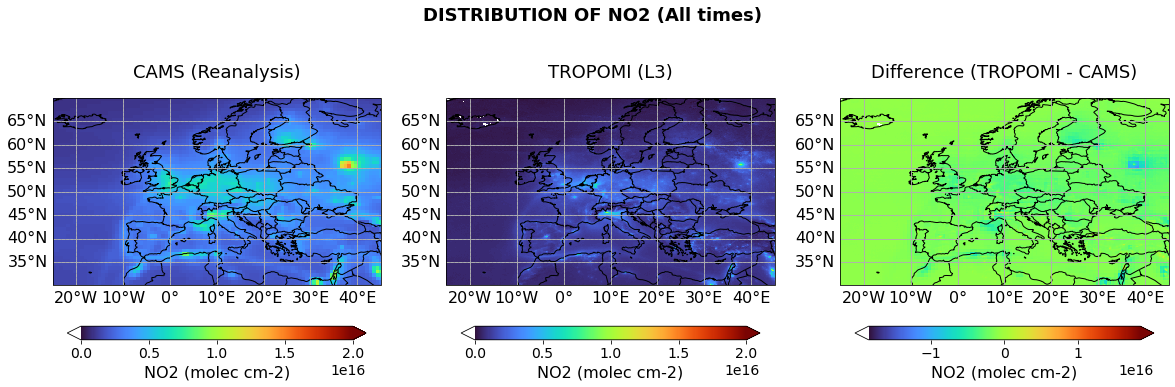

In [28]:
# Choose distribution (aggregated, individual or animated)
distribution_type = 'aggregated'

# Choose range (original, equal or manual)
range_type = 'manual'
vmin_manual = 0
vmax_manual = 2*10**16

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = 'turbo' 

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_df, plot_dates, plot_bbox, 20, 1.05, 
                          model_type, sensor_type, range_type, distribution_type, projection,
                          color_scale, vmin_manual, vmax_manual)

## 7. Retrieve nearest values to specific latitude and longitude

model_column  \
lat_search lon_search latitude longitude time                       
41.39      2.15       41.4375  2.1875    2020-01-01  5.931890e+15   
                                         2020-02-01  5.223846e+15   
                                         2020-03-01  4.524826e+15   
                                         2020-04-01  3.842444e+15   
                                         2020-05-01  3.447857e+15   
                                         2020-06-01  3.045008e+15   
                                         2020-07-01  3.063911e+15   
                                         2020-08-01  3.115908e+15   
                                         2020-09-01  4.035708e+15   
                                         2020-10-01  4.095749e+15   
                                         2020-11-01  5.207100e+15   
                                         2020-12-01  5.122551e+15   
41.10      1.65       41.0625  1.6875    2020-01-01  6.082666e+15   
                                         2020-02-01  4.567929e+15   
                                         2020-03-01  4.152966e+15   
                                         2020-04-01  3.794135e+15   
                                         2020-05-01  3.356140e+15   
                                         2020-06-01  2.940618e+15   
                                         2020-07-01  2.989653e+15   
                                         2020-08-01  2.987439e+15   
                                         2020-09-01  3.698054e+15   
                                         2020-10-01  3.735961e+15   
                                         2020-11-01  5.255797e+15   
                                         2020-12-01  4.735785e+15   

                                                     sensor_column  \
lat_search lon_search latitude longitude time                        
41.39      2.15       41.4375  2.1875    2020-01-01   9.280000e+15   
                                         2020-02-01   7.770000e+15   
                                         2020-03-01   5.900000e+15   
                                         2020-04-01   2.730000e+15   
                                         2020-05-01   3.550000e+15   
                                         2020-06-01   2.990000e+15   
                                         2020-07-01   2.830000e+15   
                                         2020-08-01   2.650000e+15   
                                         2020-09-01   4.480000e+15   
                                         2020-10-01   6.420000e+15   
                                         2020-11-01   8.790000e+15   
                                         2020-12-01   6.000000e+15   
41.10      1.65       41.0625  1.6875    2020-01-01   3.190000e+15   
                                         2020-02-01   2.550000e+15   
                                         2020-03-01   1.670000e+15   
                                         2020-04-01   1.360000e+15   
                                         2020-05-01   1.340000e+15   
                                         2020-06-01   1.240000e+15   
                                         2020-07-01   1.210000e+15   
                                         2020-08-01   1.210000e+15   
                                         2020-09-01   1.260000e+15   
                                         2020-10-01   1.680000e+15   
                                         2020-11-01   2.570000e+15   
                                         2020-12-01   2.010000e+15   

                                                       difference  \
lat_search lon_search latitude longitude time                       
41.39      2.15       41.4375  2.1875    2020-01-01  3.348110e+15   
                                         2020-02-01  2.546154e+15   
                                         2020-03-01  1.375174e+15   
                                         2020-04-01 -1.112444e+15   
                       

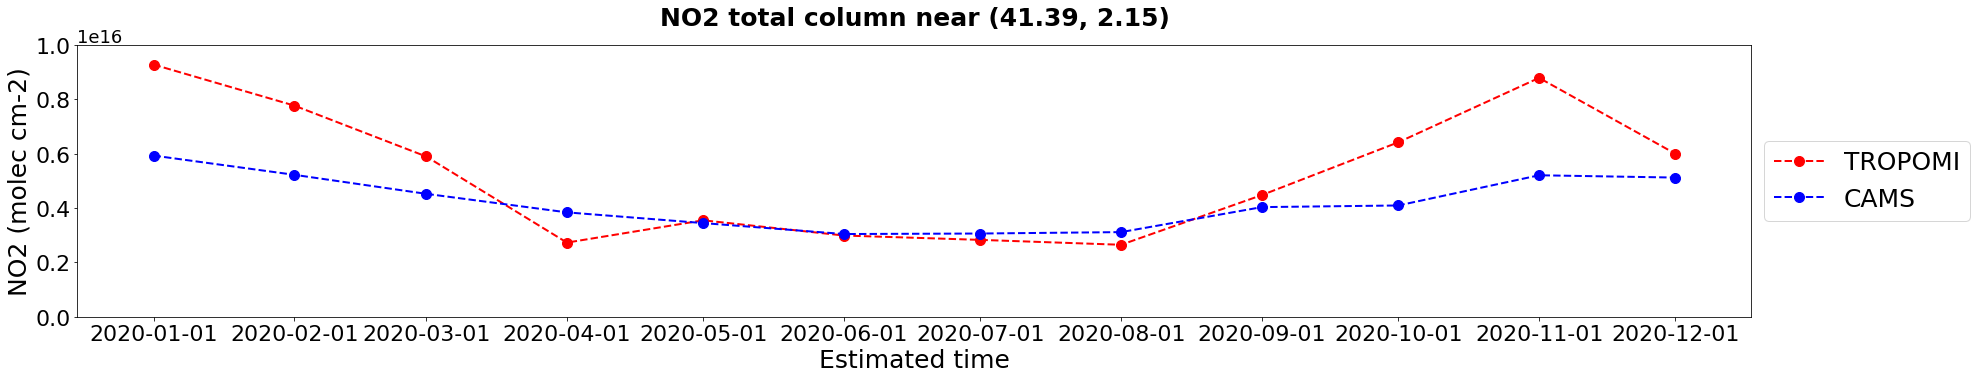

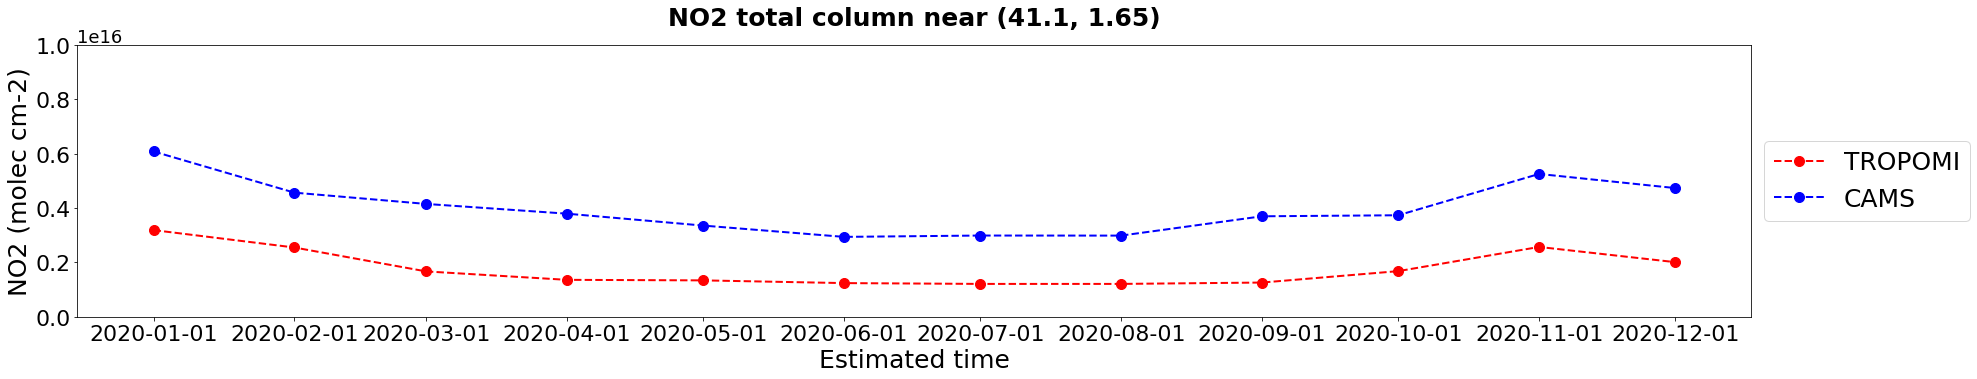

In [19]:
coords_search_list = (41.39, 2.15,
                      41.1, 1.65)
ymin = 0
ymax = 1*10**16
xticks = plot_dates
retrieval_table_all =  retrieve_coords(merge_df.dropna(), coords_search_list, component_nom, 
                                       sensor, model, plot_dates, units, ymin, ymax, xticks)
retrieval_table_all

## 8. Scatter plots by bbox

Fit equation: NO2_model = NO2_sensor * 1.34 + (1.37E+15)
Coefficient of determination (R2): 0.65


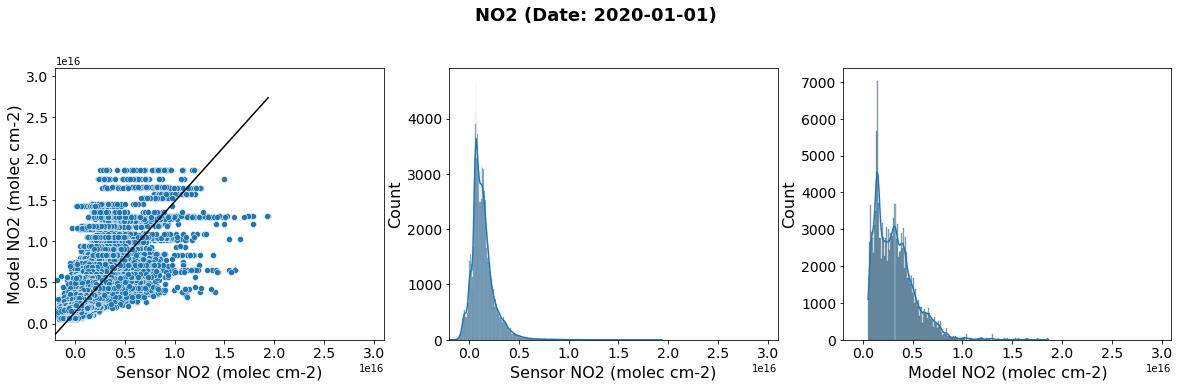

Fit equation: NO2_model = NO2_sensor * 1.38 + (1.28E+15)
Coefficient of determination (R2): 0.62


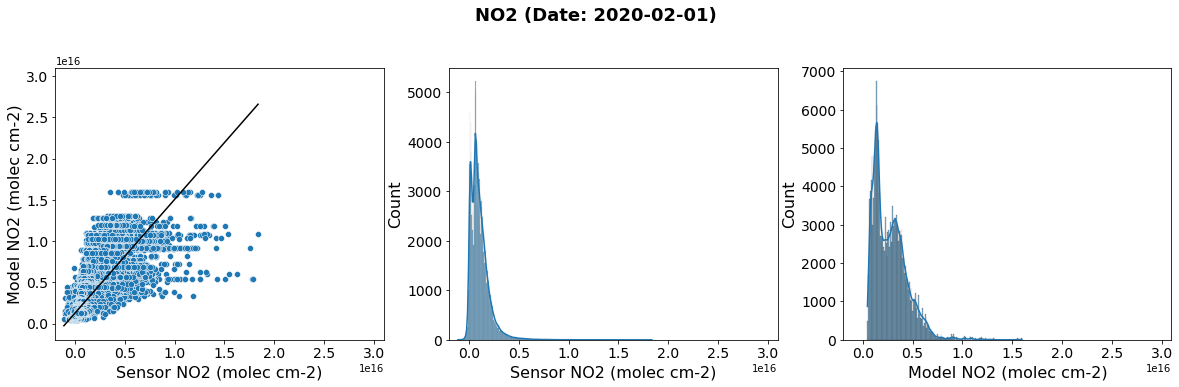

Fit equation: NO2_model = NO2_sensor * 1.55 + (1.29E+15)
Coefficient of determination (R2): 0.69


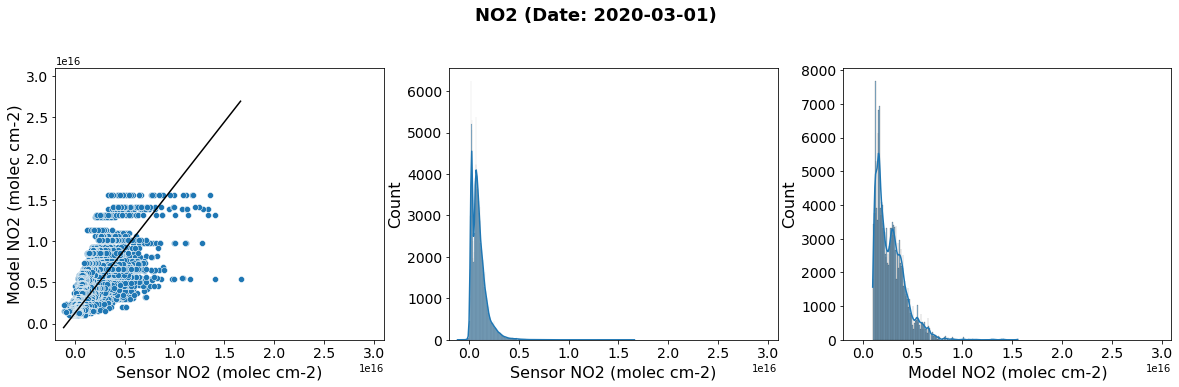

Fit equation: NO2_model = NO2_sensor * 1.58 + (9.83E+14)
Coefficient of determination (R2): 0.68


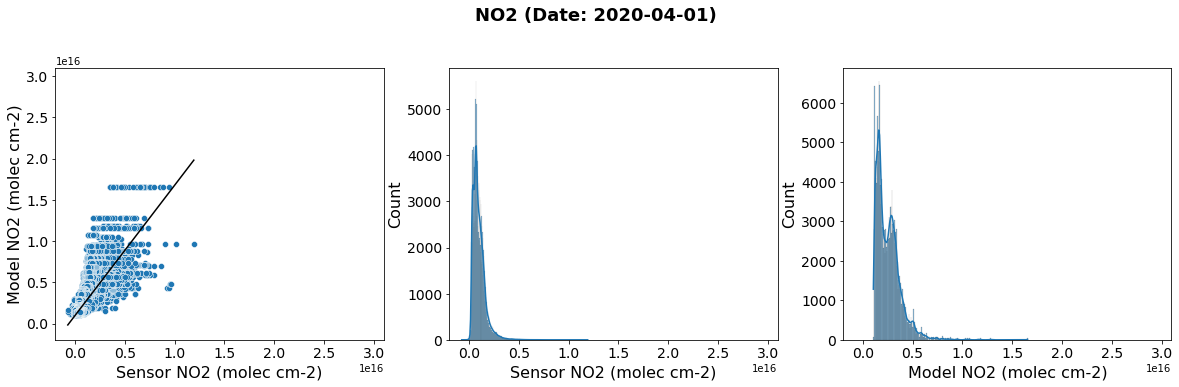

Fit equation: NO2_model = NO2_sensor * 1.55 + (1.06E+15)
Coefficient of determination (R2): 0.64


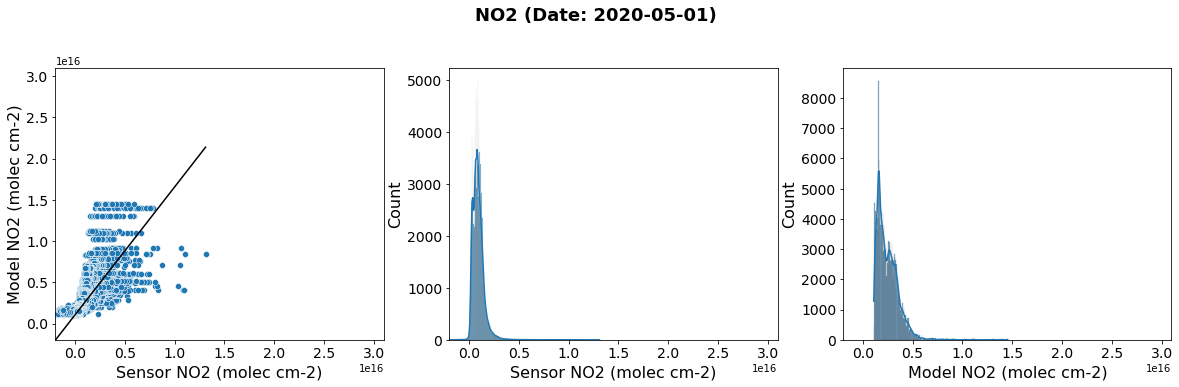

Fit equation: NO2_model = NO2_sensor * 1.73 + (8.58E+14)
Coefficient of determination (R2): 0.66


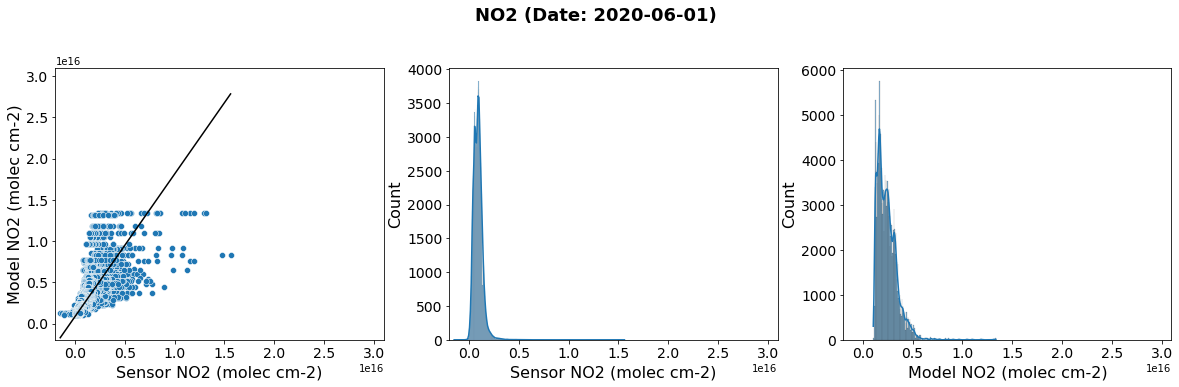

Fit equation: NO2_model = NO2_sensor * 1.43 + (1.27E+15)
Coefficient of determination (R2): 0.55


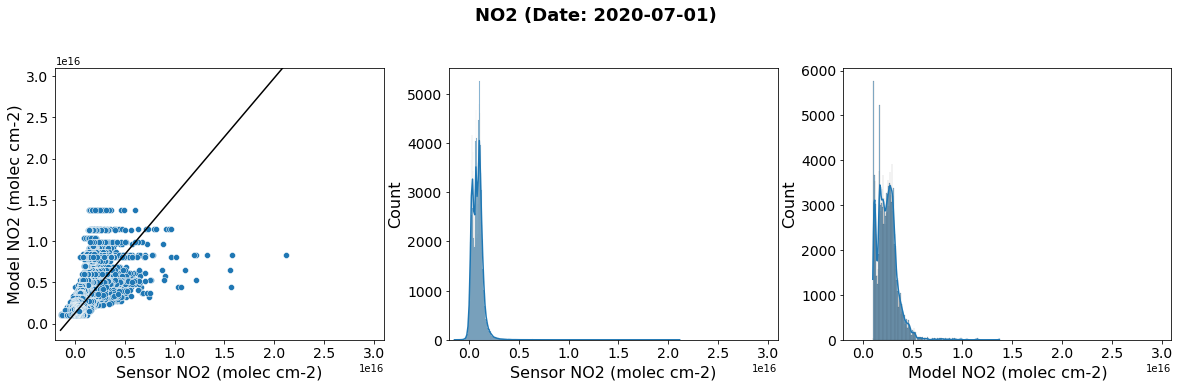

Fit equation: NO2_model = NO2_sensor * 1.71 + (8.74E+14)
Coefficient of determination (R2): 0.68


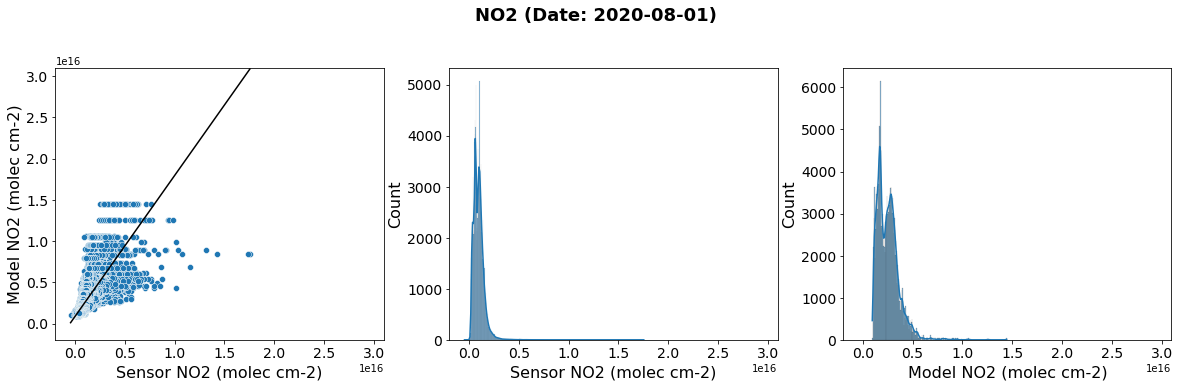

Fit equation: NO2_model = NO2_sensor * 1.50 + (1.18E+15)
Coefficient of determination (R2): 0.71


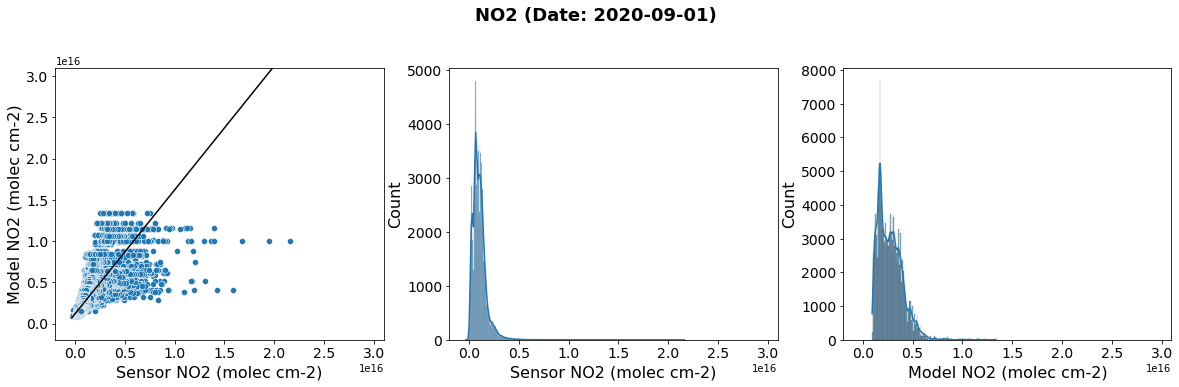

Fit equation: NO2_model = NO2_sensor * 1.66 + (1.09E+15)
Coefficient of determination (R2): 0.69


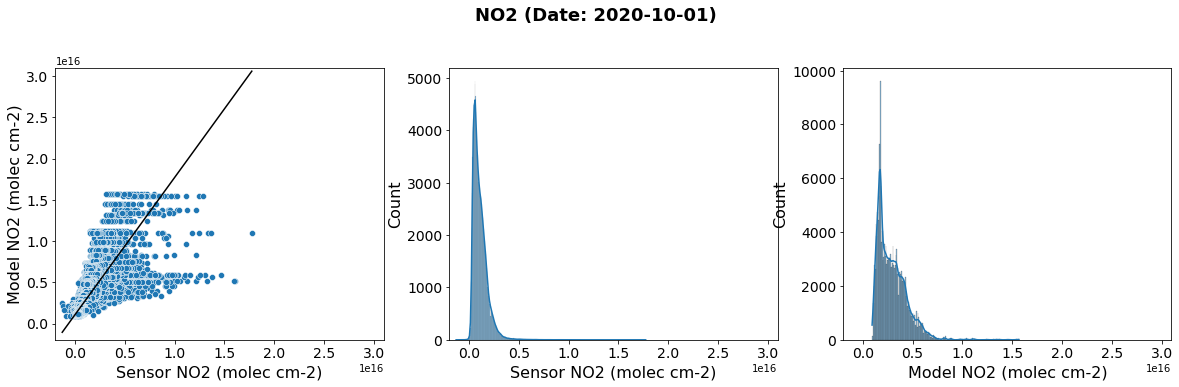

Fit equation: NO2_model = NO2_sensor * 1.28 + (1.73E+15)
Coefficient of determination (R2): 0.46


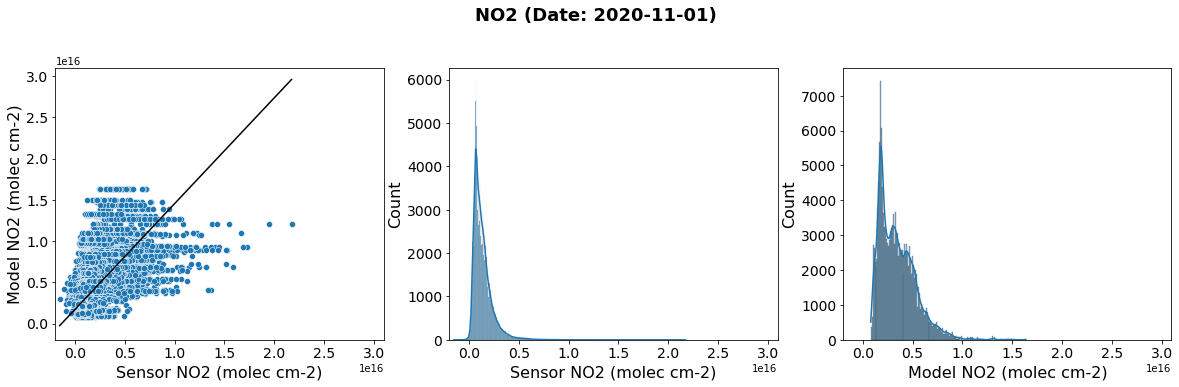

Fit equation: NO2_model = NO2_sensor * 1.32 + (1.60E+15)
Coefficient of determination (R2): 0.62


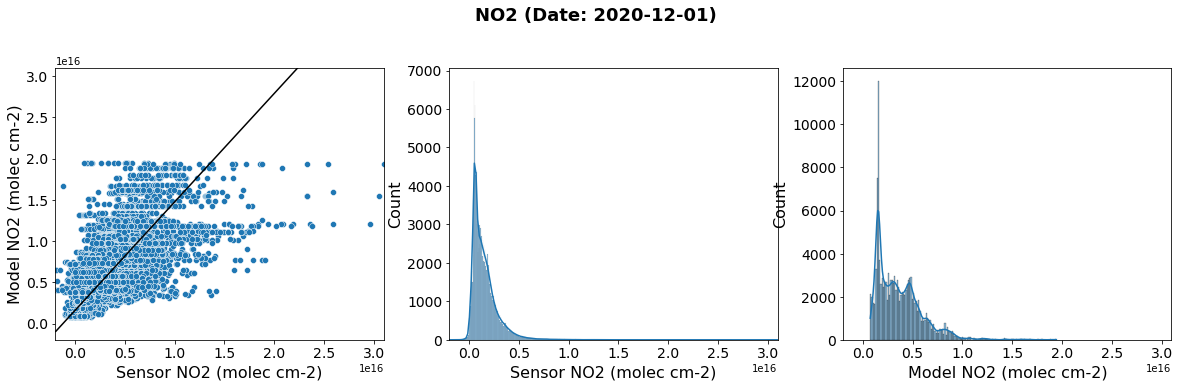

In [20]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [21]:
summary

,Period,Location,Score,Coefficient,Intercept
0,2020-01-01,"((-25, 30), (45, 70))",0.645152,1.341868,1.372437e+15
1,2020-02-01,"((-25, 30), (45, 70))",0.623024,1.377594,1.281998e+15
2,2020-03-01,"((-25, 30), (45, 70))",0.686968,1.545013,1.289124e+15
3,2020-04-01,"((-25, 30), (45, 70))",0.678073,1.579330,9.834075e+14
4,2020-05-01,"((-25, 30), (45, 70))",0.642202,1.551122,1.060664e+15
5,2020-06-01,"((-25, 30), (45, 70))",0.659174,1.728419,8.577144e+14
6,2020-07-01,"((-25, 30), (45, 70))",0.550324,1.425462,1.272751e+15
7,2020-08-01,"((-25, 30), (45, 70))",0.680464,1.708743,8.737386e+14
8,2020-09-01,"((-25, 30), (45, 70))",0.708422,1.502980,1.181324e+15
9,2020-10-01,"((-25, 30), (45, 70))",0.690840,1.663396,1.086876e+15


## 9. Scatter plots by season

Fit equation: NO2_model = NO2_sensor * 1.46 + (1.24E+15)
Coefficient of determination (R2): 0.64


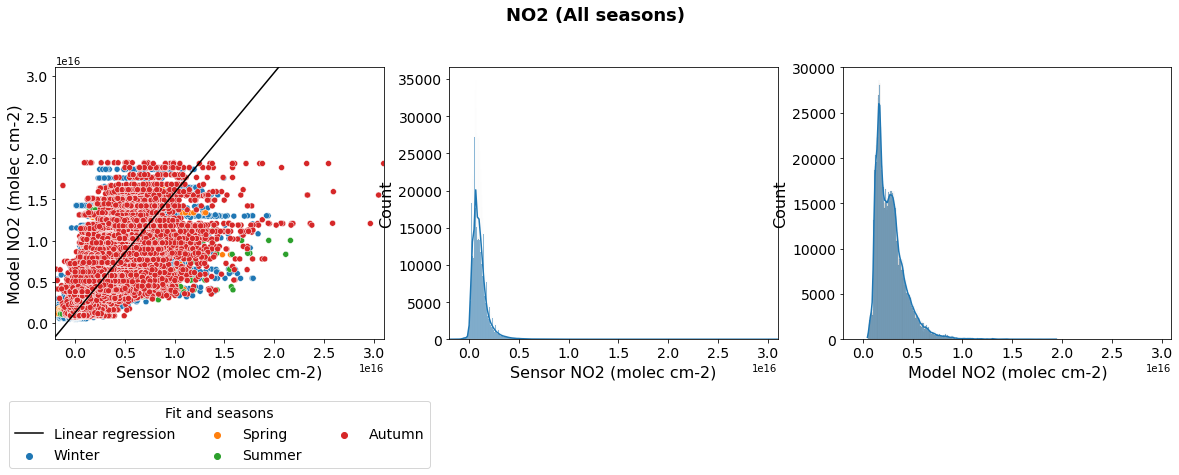

In [22]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [23]:
summary

,Period,Location,Score,Coefficient,Intercept
0,"[Autumn, Spring, Summer, Winter]","((-25, 30), (45, 70))",0.637228,1.456443,1.238862e+15


## 10. Scatter plots by country (Google API required!)

In [24]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual
plot_countries = ['Czech Republic', 'Poland', 'Germany']

lim_min = None
lim_max = None

scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
             extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'aggregated' # aggregated or individual\nplot_countries = ['Czech Republic', 'Poland', 'Germany']\n\nlim_min = None\nlim_max = None\n\nscatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1.05, \n             extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)\n"

In [25]:
#summary